# Example for Fixing Stripes in a 2D Image

This Jupyter notebook demonstrates the step-by-step process of fixing the striping effect in a 2D image. All the essential functions from the `FixImage3D` class are defined here. The sample data used for this demonstration is "SampleData_AFM010_level_300.h5."

**Note:** The stripe fixing function may not work optimally for images with significant empty spaces or tissues with a lot of hollow structure.

*This notebook focuses on stripefix only. For both stripefix and depthfix, please follow the quick run guide provided in the readme file.*

In [21]:
# Import python library
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

**Defining Helper Functions**

`getBackgroundLevels(image, threshold=50)`

This function calculates foreground and background values based on image statistics. The background value is currently set to be 20% of the foreground. 

`stripe_fix(img)`

This function fixes the vertical striping effect in the 2D image by dividing each row by the sum of binning all columns.

**Viewing Images in Jupyter Notebook**

 `view_slice` allows us to view images in a Jupyter notebook. This will help us visualize the original and corrected images.

In [22]:
def getBackgroundLevels(image, threshold=50):
    """
    Calculate foreground and background values based on image
    statistics, background is currently set to be 20% of foreground.

    Params:
    - image : 2D numpy array
    - threshold : int, threshold above which is counted as foreground

    Returns:
    - hi_val : int, Foreground values
    - background : int, Background value
    """

    image_DS = np.sort(image, axis=None)
    foreground_vals = image_DS[np.where(image_DS > threshold)]
    hi_val = foreground_vals[int(np.round(len(foreground_vals)*0.95))]
    background = hi_val/5

    return hi_val, background


def stripe_fix(img):
    """
    Fix the vertical striping effect;
    dividing each row in the image by the sum of binning all columns.

    Params: 
    - img : 2D numpy array
    
    Returns: 
    - img_nobg : stripe-fixed image
    """
    # Get background
    img_background = getBackgroundLevels(img)[1]
    img_nobg = np.clip(img - 0.5*img_background, 0, 2**16)

    # Calculate profiles with background removed 
    line_prof_n_nobg = img_nobg.sum(axis=0)
    line_prof_n_nobg = line_prof_n_nobg/np.max(line_prof_n_nobg)

    # Divide the 2D image with the horizontal line profile
    img_nobg /= line_prof_n_nobg[np.newaxis, :]
    img_nobg[img_nobg<0] = 0 # To ensure no negative vals
    
    return img_nobg.astype(np.uint16)


def view_slice(volume, index=0, figsize=(6, 6), vmax = 3000, title = ""):
    """
    Method for viewing 3D images in a jupyter notebook

    Params: 
    - volume : 3D or 2D numpy array
    - index(int) : which level to display, defaults to zero

    """
    fig, ax = plt.subplots(figsize=figsize)
    plt.tick_params(axis='both', which='both', top=False,
                    bottom=False, left=False, right=False,
                    labelbottom=False, labelleft=False)
    ax.volume = volume
    ax.index = index
    ax.set_title(title)
    ax.imshow(volume[ax.index], cmap="gray", vmax=vmax)


**Loading and Processing the Data**

In [23]:
h5path = "SampleData_AFM010_level_300.h5"
chan = "s01" # Cyto channel
res = "0"

print("reading .h5 file...")
with h5.File(h5path, 'r') as f:
    img = f['t00000'][chan][res]['cells'][:,:,:].astype(np.uint16)
f.close()

img_corrected = np.zeros_like(img)
print("converting..")
for i in range(len(img)):
    img_corrected[i] = stripe_fix(img[i])

reading .h5 file...
converting..


**Visualizing the Results**

View the original and corrected images to compare the stripe-fixing results:

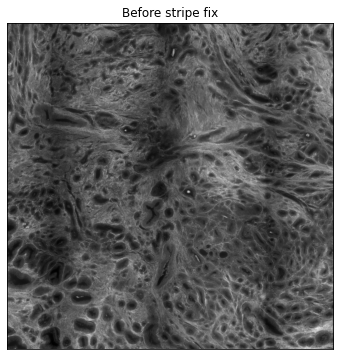

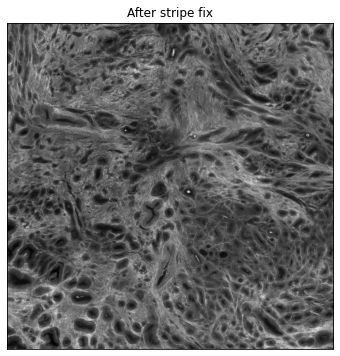

In [24]:
view_slice(img, vmax = 2700, title="Before stripe fix")
view_slice(img_corrected, vmax = 2700, title="After stripe fix")